# Imports

In [14]:
import torch
import torch.nn as nn
import torchvision
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
from datetime import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from sklearn import preprocessing

# Pytorch settings and hyperparameters

In [15]:
torch.set_printoptions(precision=8)
DEVICE = torch.device('cuda' if torch.cuda.is_available else 'cpu')
DEVICE = torch.device('cpu')

WINDOW = 4
NUM_EPOCHS = 1000
BATCH_SIZE = 6
INPUT_SIZE = 4
HIDDEN_SIZE = 1
LSTM_LAYERS = 1
OUTPUT_SIZE = 1
LEARNING_RATE = 0.00005

# Download stock data

In [16]:
stock_data_df = yf.download('USDEUR=X', 
                      period='10y', 
                      interval='1d', 
                      progress=False, 
                    #   start='2011-01-01', 
                    #   end='2021-01-01'
                      )
stock_data_df.head(10)
stock_data_df.tail(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-11-15,0.96906,0.96957,0.95461,0.96906,0.96906,0
2022-11-16,0.96545,0.96745,0.95810,0.96545,0.96545,0
2022-11-17,0.96200,0.96998,0.96101,0.96200,0.96200,0
2022-11-18,0.96509,0.96824,0.96192,0.96509,0.96509,0
2022-11-21,0.96797,0.97780,0.96775,0.96797,0.96797,0
2022-11-22,0.97602,0.97624,0.97180,0.97602,0.97602,0
2022-11-23,0.96983,0.97105,0.96320,0.96983,0.96983,0
2022-11-24,0.96004,0.96305,0.95710,0.96004,0.96004,0
2022-11-25,0.96079,0.96561,0.95886,0.96079,0.96079,0


### Features

In [17]:
features = stock_data_df.iloc[:, [0,1,2,5]]
features.head()

,Open,High,Low,Volume
Date,,,,
2012-11-28,0.7729,0.776241,0.772800,0
2012-11-29,0.7720,0.772800,0.768580,0
2012-11-30,0.7708,0.771000,0.767542,0
2012-12-03,0.7694,0.769520,0.764760,0
2012-12-05,0.7634,0.765490,0.761900,0


### Closing prices

In [18]:
closing = stock_data_df.iloc[:, [3]]
closing.head()

,Close
Date,
2012-11-28,0.77290
2012-11-29,0.77200
2012-11-30,0.77080
2012-12-03,0.76942
2012-12-05,0.76340


# Standardization

In [19]:
scaler = preprocessing.StandardScaler()

features_std = scaler.fit_transform(features.values)
features_std = pd.DataFrame(columns=features.columns, data=features_std, index=features.index)

In [20]:
features_std.head()

,Open,High,Low,Volume
Date,,,,
2012-11-28,-1.287217,-1.267805,-1.259489,0.0
2012-11-29,-1.300566,-1.318386,-1.322663,0.0
2012-11-30,-1.318365,-1.344845,-1.338202,0.0
2012-12-03,-1.339131,-1.366601,-1.379848,0.0
2012-12-05,-1.428127,-1.425839,-1.422663,0.0


### Processing the data into windows

In [21]:
def lstm_split(features, target, window):
    x, y = [], []
    for i in range(len(features)-window):
        x.append(features[i:i + window, :])
        y.append(target[i + window, -1])
    return np.array(x), np.array(y)

train, target = lstm_split(features_std.values, closing.values, WINDOW)


### If the dataset doesn't fit the batch size, cut off a part

In [22]:
if train.shape[0] % BATCH_SIZE > 0:
    train = train[:-(train.shape[0] % BATCH_SIZE)]
    target = target[:-(target.shape[0] % BATCH_SIZE)]
train = np.reshape(train, (int(train.shape[0]/BATCH_SIZE), BATCH_SIZE, WINDOW, INPUT_SIZE))
target = np.reshape(target, (int(target.shape[0]/BATCH_SIZE), BATCH_SIZE))

In [23]:
print(train[0])
print(f'Shape: {train.shape}')

[[[-1.28721677 -1.26780539 -1.25948909  0.        ]
  [-1.30056574 -1.31838583 -1.32266285  0.        ]
  [-1.31836525 -1.34484483 -1.33820198  0.        ]
  [-1.33913091 -1.36660064 -1.37984848  0.        ]]

 [[-1.30056574 -1.31838583 -1.32266285  0.        ]
  [-1.31836525 -1.34484483 -1.33820198  0.        ]
  [-1.33913091 -1.36660064 -1.37984848  0.        ]
  [-1.42812669 -1.42583924 -1.42266298  0.        ]]

 [[-1.31836525 -1.34484483 -1.33820198  0.        ]
  [-1.33913091 -1.36660064 -1.37984848  0.        ]
  [-1.42812669 -1.42583924 -1.42266298  0.        ]
  [-1.40291138 -1.35292999 -1.38754355  0.        ]]

 [[-1.33913091 -1.36660064 -1.37984848  0.        ]
  [-1.42812669 -1.42583924 -1.42266298  0.        ]
  [-1.40291138 -1.35292999 -1.38754355  0.        ]
  [-1.30946594 -1.26762928 -1.28987852  0.        ]]

 [[-1.42812669 -1.42583924 -1.42266298  0.        ]
  [-1.40291138 -1.35292999 -1.38754355  0.        ]
  [-1.30946594 -1.26762928 -1.28987852  0.        ]
  [-

In [24]:
print(target[0])
print(f'Shape: {target.shape}')

[0.76340002 0.7651     0.77139997 0.77482998 0.77289999 0.76845002]
Shape: (433, 6)


# Model definition

In [25]:
class Financial(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(HIDDEN_SIZE * WINDOW, output_size)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        out = self.lstm(x)
        out = torch.reshape(out[0], (1 * BATCH_SIZE, HIDDEN_SIZE * WINDOW))
        out = self.linear(out)
        return out

MODEL = Financial(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, output_size=OUTPUT_SIZE, num_layers=LSTM_LAYERS).to(DEVICE)
CRITERION = nn.MSELoss()
OPTIMIZER = torch.optim.Adam(MODEL.parameters(), lr=LEARNING_RATE)

## Training loop

In [26]:
loss_data = []
for epoch in range(NUM_EPOCHS):
    for i in range(len(train)):
        train_tens = torch.tensor(train[i], dtype=torch.float).to(DEVICE)
        target_tens = torch.tensor(target[i], dtype=torch.float).to(DEVICE)
        output = MODEL(train_tens)
        target_tens = torch.reshape(target_tens, (1 * BATCH_SIZE,1))
        loss = CRITERION(output, target_tens)
        OPTIMIZER.zero_grad()
        loss.backward()
        OPTIMIZER.step()
    if epoch == 20:
        LEARNING_RATE /= 10

    loss_data.append(loss.item())

    print(f'this is {epoch+1} / {NUM_EPOCHS}, learning rate {LEARNING_RATE}, loss = {loss.item():.6}')
    # print(f'Predicted: {output[0]}, Target: {target[i]}')

this is 1 / 1000, learning rate 5e-05, loss = 1.66832
this is 2 / 1000, learning rate 5e-05, loss = 1.55965
this is 3 / 1000, learning rate 5e-05, loss = 1.44025
this is 4 / 1000, learning rate 5e-05, loss = 1.31044
this is 5 / 1000, learning rate 5e-05, loss = 1.17201
this is 6 / 1000, learning rate 5e-05, loss = 1.02787
this is 7 / 1000, learning rate 5e-05, loss = 0.881569
this is 8 / 1000, learning rate 5e-05, loss = 0.737047
this is 9 / 1000, learning rate 5e-05, loss = 0.598251
this is 10 / 1000, learning rate 5e-05, loss = 0.468879
this is 11 / 1000, learning rate 5e-05, loss = 0.352159
this is 12 / 1000, learning rate 5e-05, loss = 0.250668
this is 13 / 1000, learning rate 5e-05, loss = 0.166213
this is 14 / 1000, learning rate 5e-05, loss = 0.0997381
this is 15 / 1000, learning rate 5e-05, loss = 0.0512825
this is 16 / 1000, learning rate 5e-05, loss = 0.019953
this is 17 / 1000, learning rate 5e-05, loss = 0.00392158
this is 18 / 1000, learning rate 5e-05, loss = 0.000467134


In [27]:
# with torch.no_grad():
#     for i in range(len(train)):
#         output = MODEL(torch.tensor(train[i], dtype=torch.float))
#         print(output)
#         print(target[i])

# Evaluation

### Loss function

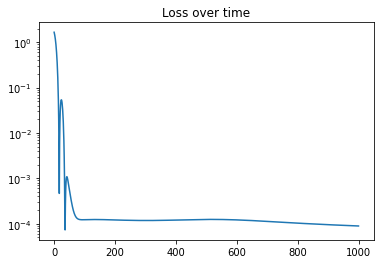

In [28]:
fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.set_yscale('log')
ax.set_title('Loss over time')
ax.plot(range(len(loss_data)), loss_data);  # Plot some data on the axes.

### Price vs. predicted price

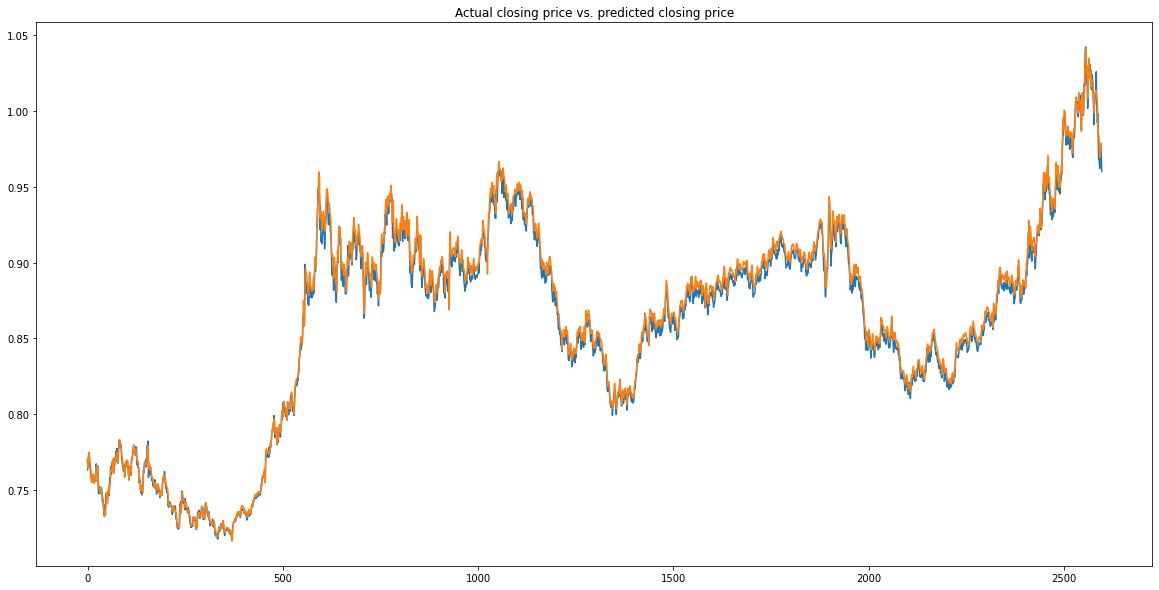

In [31]:
x_limit_l = 1500
x_limit_r = 1700

with torch.no_grad():
    output_data = []
    for i in range(len(train)):
        test_out = MODEL(torch.tensor(train[i], dtype=torch.float))
        test_out = [x.item() for x in test_out]
        output_data += test_out
    
    fig, ax = plt.subplots()  # Create a figure containing a single axes.
    ax.set_title('Actual closing price vs. predicted closing price')
    fig.set_size_inches(20, 10)
    
    # plt.xlim(x_limit_l, x_limit_r)
    ax.plot(range(len(output_data)), target.reshape((target.shape[0] * target.shape[1])));  # Plot some data on the axes.
    ax.plot(range(-1, len(output_data)-1), output_data);  # Plot some data on the axes.

### Trading evaluation

Prediction should be: 0.7634000182151794
prediction:           0.7703615427017212
Previous close        0.7728999853134155
end balance is: [113111.688913]


0.012444284610376277

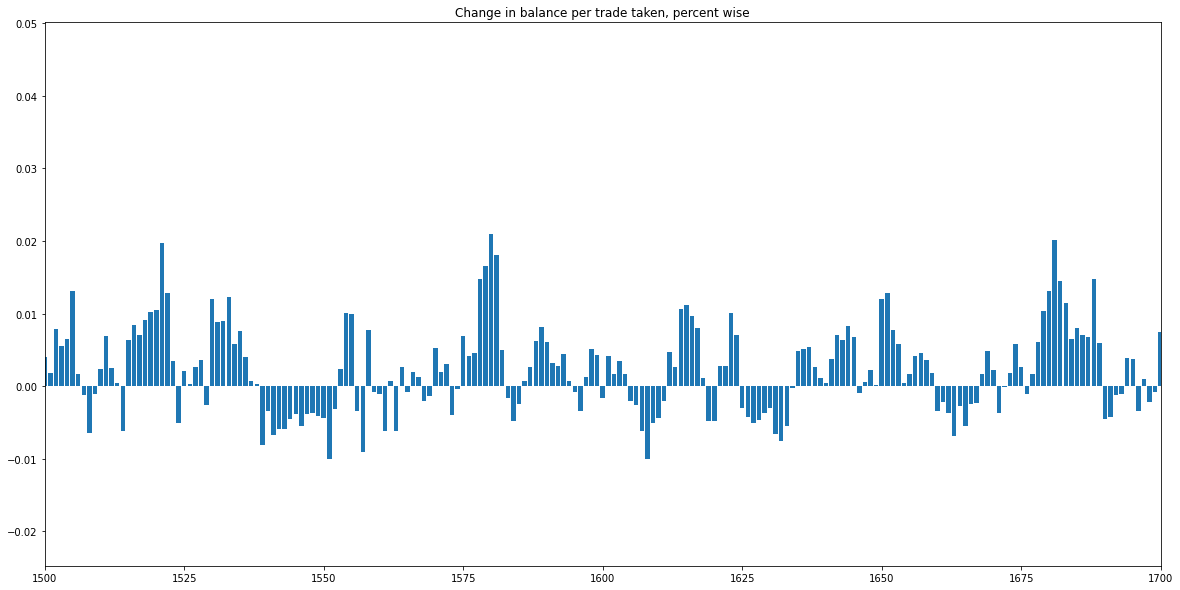

In [30]:
def change(prediction, previous):
    return prediction / previous

trade_if_change_larger_than = 0.00

balance = 100.0
change_list = []
index_list = []
target_test = target.reshape((target.shape[0] * target.shape[1]))
with torch.no_grad():
    print(f'Prediction should be: {target_test[0]}')
    print(f'prediction:           {output_data[0]}')
    print(f'Previous close        {closing.values[0][0]}')
    for i in range(len(output_data)):
        close_prediction = output_data[i]
        prev_close = closing.values[i]
        real_close = target_test[i]
        

        if close_prediction > prev_close and change(close_prediction, prev_close)-1 > trade_if_change_larger_than:
            balance = change(real_close, prev_close) * balance
            change_list.append((change(real_close, prev_close) - 1).item())

        if close_prediction < prev_close and 1 / (change(close_prediction, prev_close)-1) > trade_if_change_larger_than:
            balance = (1 / change(real_close, prev_close)) * balance
            change_list.append((1 / change(real_close, prev_close) - 1).item())

print(f'end balance is: {balance}')


fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.set_title('Change in balance per trade taken, percent wise')
fig.set_size_inches(20, 10)

plt.xlim(x_limit_l, x_limit_r)
ax.bar(range(len(change_list)), change_list)
change_list[0]
